## Photometry With MCMC

Having gotten the target files in the previous notebook, I'm going to now use the file `corecomposition/photometry.py` to fetch more photometry from either DES or PANSTARRS. Then, I'll run MCMC with a much better constraint on the temperature which will also give me a better constraint on the radius. 

First, I'll read in the gold, silver, and bronze samples. The gold and silver samples are both subsets of the bronze sample, so I'll do all of the analysis on the bronze table (since that will also analyze the stars in the gold and silver samples). 

In [1]:
### general
import numpy as np
import pickle
import matplotlib.pyplot as plt

### astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join

### project-specific
import sys
sys.path.append('../')
import corecomposition as cc

gold = Table.read('../data/processed/gold.csv')
silver = Table.read('../data/processed/silver.csv')
bronze = Table.read('../data/processed/bronze.csv')

The function `corecomposition/photometry.py:fetch_photometry()` uses `TAP` to query DES and PANSTARRS for extra photometry. I use DES's published conversion functions to turn their photometry into PANSTARRS bands, and prefer that over actual PANSTARRS photometry wherever possible. 

In [2]:
photo = cc.photometry.fetch_photometry(bronze['wd_source_id']) # fetch PANSTARRS and DES photometry for the source_ids in the sample
bronze = join(bronze, photo, keys_left='wd_source_id', keys_right='source_id') # join the two on the wd source_id


        SELECT gs.source_id, gs.original_ext_source_id
        FROM gaiadr3.panstarrs1_best_neighbour as gs
        WHERE gs.source_id in (289141738147968768, 321259125631010688, 397511665765717632, 561759873818711040, 600363963295676672, 602387893616904960, 652986456654102144, 820389369726105984, 853846924444089344, 1005480710471506304, 1158693871933588992, 1221350645852148224, 1258660610138468096, 1307515077152381568, 1344935409214891520, 1498859993356856192, 1670570823050183808, 1792836069385045760, 1859234167837456384, 1889409474189137152, 1895697134508504704, 1946867001216898816, 1956990406636103296, 2033937086539674752, 2084572311384460672, 2153552814748001792, 2227145881073198464, 2228711207670801408, 2347362359280261248, 2376773024012888832, 2401835670014014080, 2577004017102144256, 2588314594431036416, 2690318895188779136, 2809172631816775168, 2885703352688857856, 2903789322533760512, 3090038517737811712, 3121385658671190784, 3267693925768589696, 3305291519719761280, 35524697

The photometry is processed in several steps:
1. The Gaia photometry is collected, and the G-band magnitude is corrected using Tyler's code.
2. Extra photometry is collected by querying DES and PANSTARRS, and that is added to the list of photometry.
3. The photometry is dereddened using the Edenhofer+2023 dustmap.
4. Tyler's code is used to fit teff and radius using the available bands with MCMC.

In the next two cells, I collect all the information that will be necessary to run the MCMC fit. I use the radius and teff fitted with least squares as the initial guess for MCMC to hopefully avoid false minima.

In [3]:
# information needed for MCMC fitting each target
source_ids = bronze['wd_source_id'] # array of source_ids
coords = [SkyCoord(frame="galactic", l=bronze['wd_l'][i]*u.deg, b=bronze['wd_b'][i]*u.deg, distance = bronze['r_med_geo'][i] * u.pc) for i in range(len(bronze))] # contains the locations of each target
astrometric_params = bronze['wd_astrometric_params_solved'] # used for correcting g-band in Tyler's code
photo = np.array([bronze['wd_phot_g_mean_mag'], bronze['wd_phot_bp_mean_mag'], bronze['wd_phot_rp_mean_mag']]).T # the basic Gaia photometry
e_photo = np.array([bronze['wd_e_gmag'], bronze['wd_e_bpmag'], bronze['wd_e_rpmag']]).T # Gaia photometry error
initial_params = np.array([[10000]*len(bronze), bronze['cmd_radius']]).T # initial guesses

Now, I can pass this information to the class `corecomposition/photometry.py:Photometry()` which will automatically collect the DES/PANSTARRS photometry, apply the G-band correction, apply dereddening to each band, and get everything in order to perform the MCMC fit.

In [4]:
obj = cc.photometry.Photometry(source_ids, coords, astrometric_params, photo, e_photo, initial_params)


        SELECT gs.source_id, gs.original_ext_source_id
        FROM gaiadr3.panstarrs1_best_neighbour as gs
        WHERE gs.source_id in (820389369726105984, 1005480710471506304, 1158693871933588992, 1307515077152381568, 1670570823050183808, 1792836069385045760, 1859234167837456384, 1889409474189137152, 1895697134508504704, 2033937086539674752, 2084572311384460672, 2153552814748001792, 2347362359280261248, 2376773024012888832, 2577004017102144256, 2690318895188779136, 2809172631816775168, 3090038517737811712, 3121385658671190784, 3267693925768589696, 3305291519719761280, 3552469739463127808, 3754176938580696064, 3807992810079236736, 3827551094712817920, 3970162318385391488, 4248619071266347648, 4595031204703995136, 5750618956285716480, 6620463598819012352, 6832187963045348864, 6845104475892604672, 6878408889256318720)
        


100%|██████████| 37/37 [00:00<00:00, 610.42it/s]


In [5]:
# array([20.69774628, 20.85405159, 20.11615562, 21.40539932, 20.65850067, 20.30249977, 20.21529961, 20.07729912])

In [6]:
# print the magnitudes of the first target's bands
obj.photometry[0]

array([20.69774628, 20.85405159, 20.11615562, 21.49829674, 20.51503754,
       19.93934059, 19.70825386, 19.53839684])

Running this many MCMC fits takes a while, so I save the chains in a dictionary whose keys are the Gaia source ids. I've pre-computed the CO core compositions, which I load in in the next cell. Because it takes so long to run, I've set the cells to `raw` so that they won't run by default. 

In [7]:
with open('../data/cleaned/radius_chains_CO_Hdef.pkl', 'rb') as f:
    co_hdef_chains = pickle.load(f)

with open('../data/cleaned/radius_chains_CO_Hrich.pkl', 'rb') as f:
    co_hrich_chains = pickle.load(f)

#with open('../data/cleaned/radius_chains_ONe_Hdef.pkl', 'rb') as f:
#    one_hdef_chains = pickle.load(f)

#with open('../data/cleaned/radius_chains_ONe_Hrich.pkl', 'rb') as f:
#    one_hrich_chains = pickle.load(f)

### Results (Bronze Sample)

Below I plot the posterior radii for the entire sample. There's some weirdness here. I suspect that this is because of the weirdness 

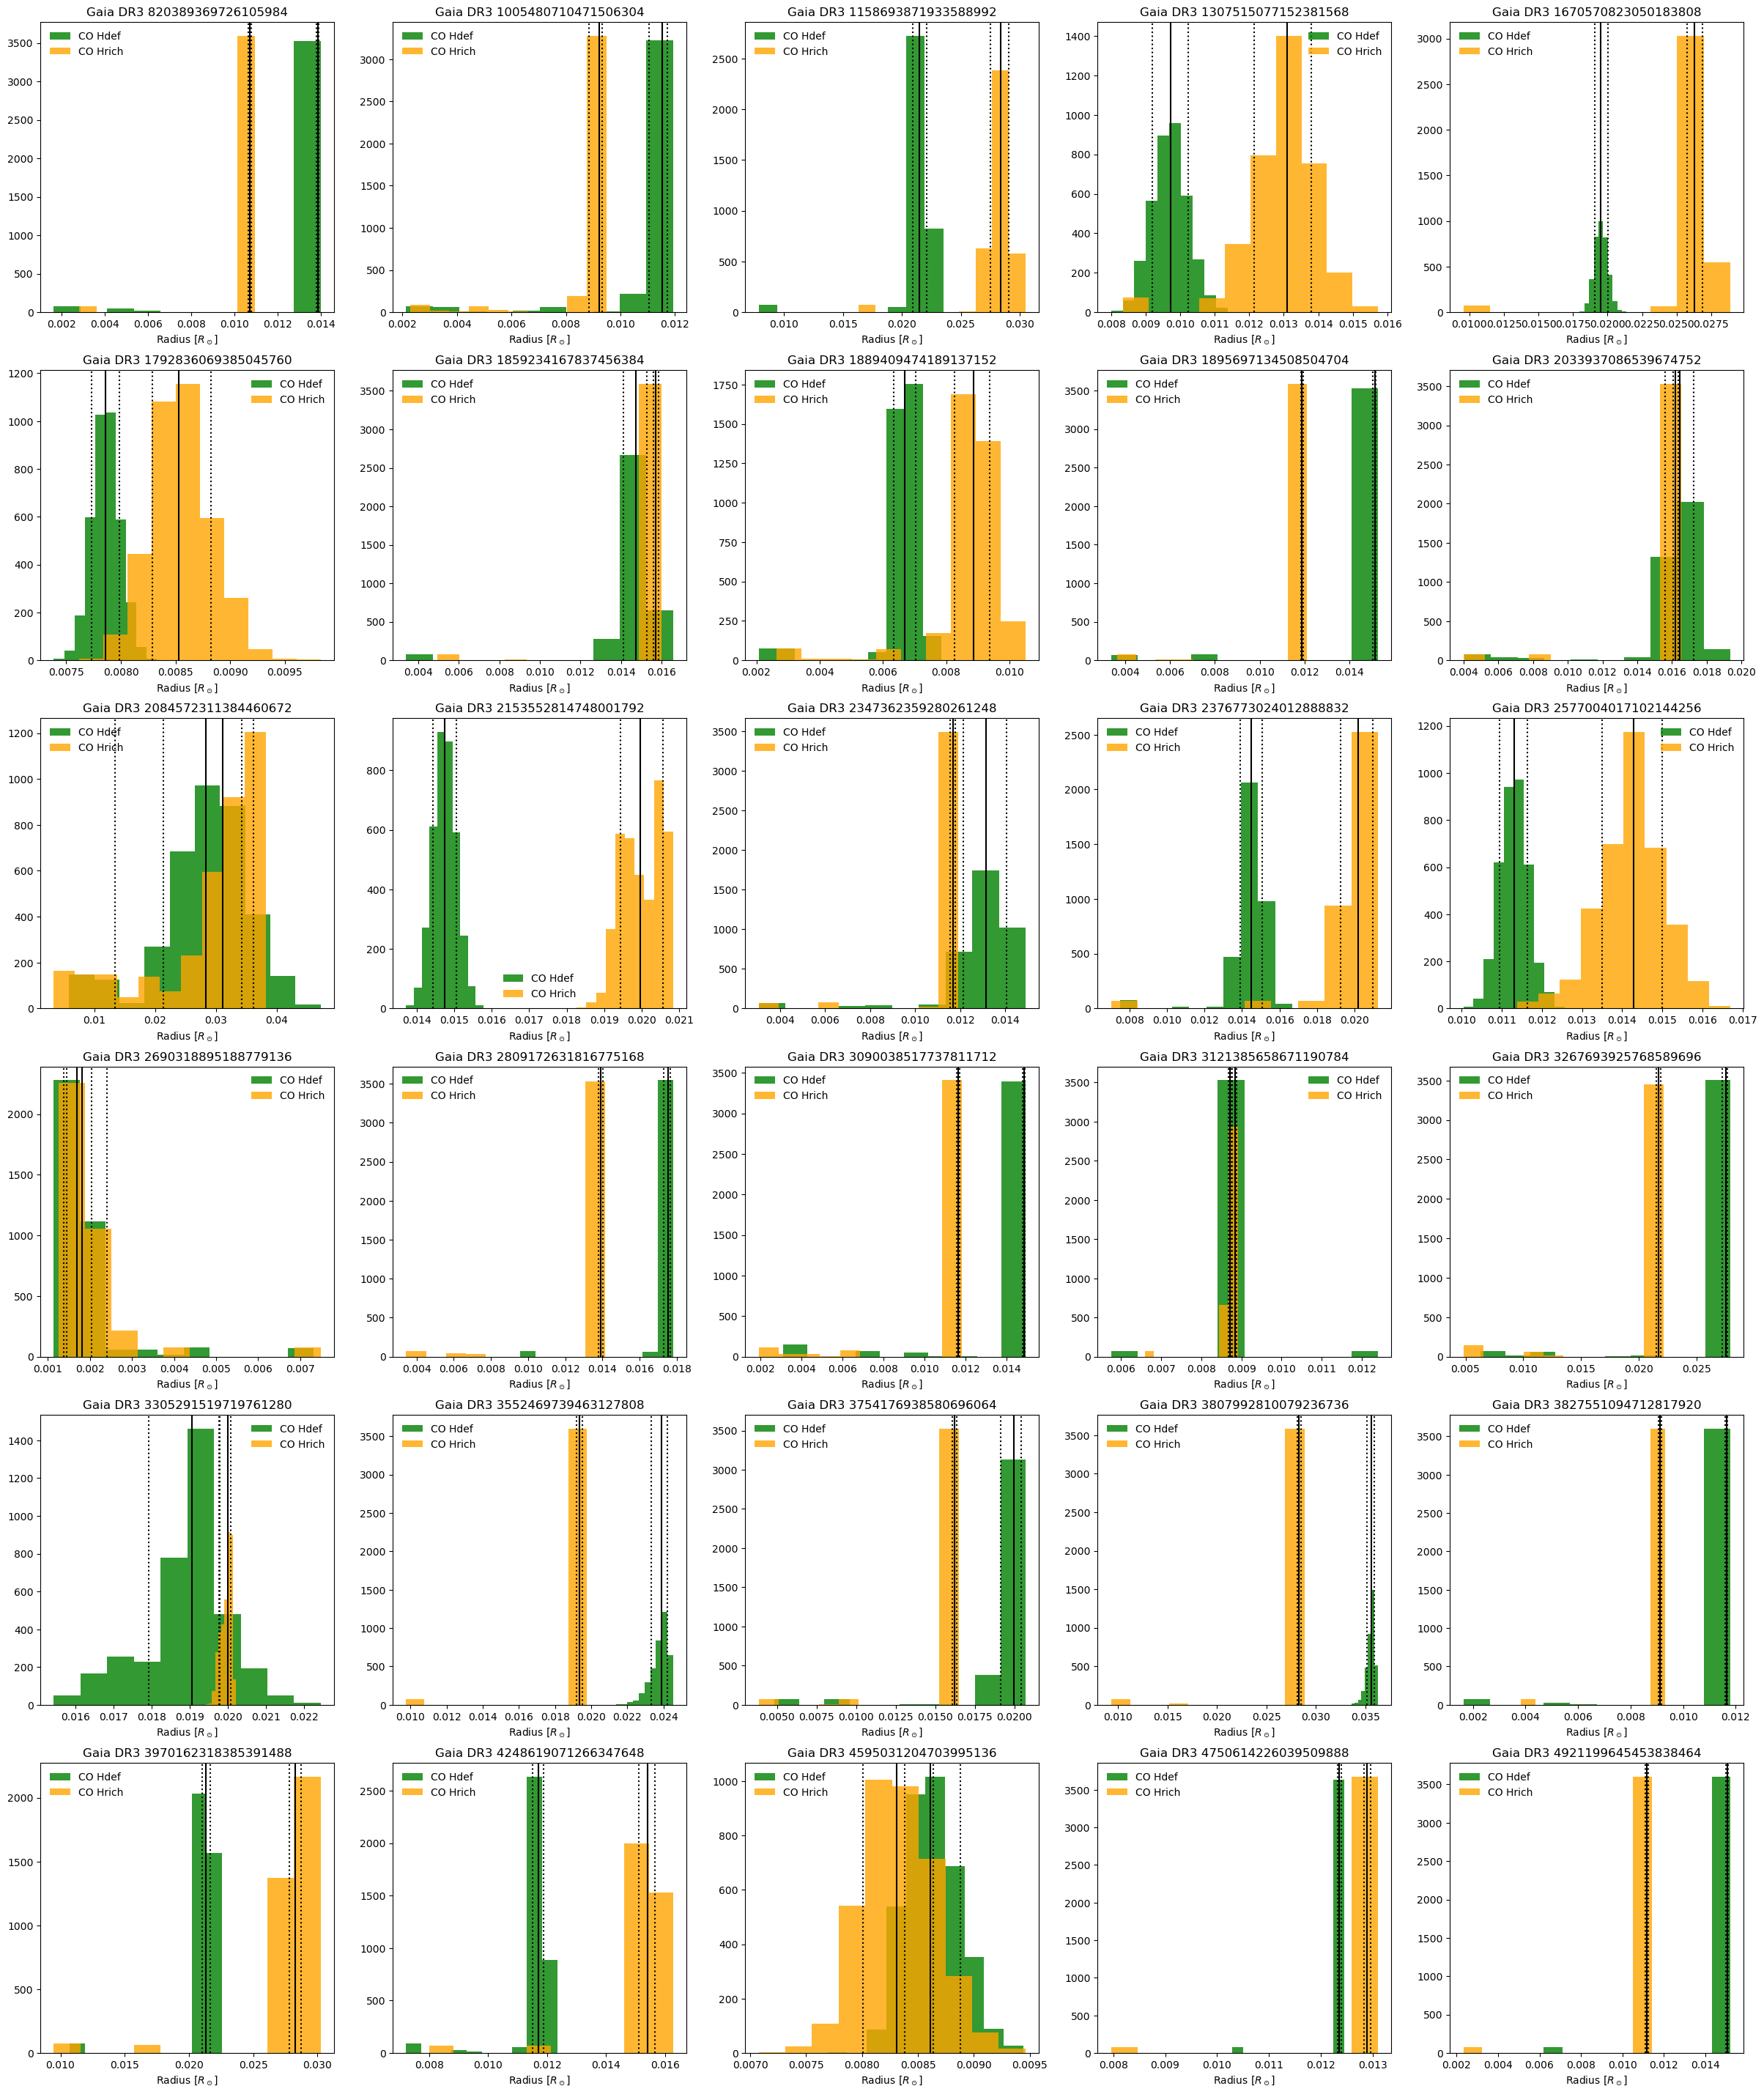

In [8]:
fig, ax = plt.subplots(nrows = 6, ncols = 5, figsize=(30, 36))
burn = 0.25

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        n = (i * ax.shape[1]) + j
        try:
            id = list(co_hdef_chains.keys())[n]
        except:
            break

        ax[i,j].set_title(f'Gaia DR3 {id}')
        co_hdef_burn = int(burn * co_hdef_chains[id].shape[0])
        co_hrich_burn = int(burn * co_hrich_chains[id].shape[0])

        ax[i,j].hist(co_hdef_chains[id][co_hdef_burn:,1], color = 'green', alpha = 0.8, label = 'CO Hdef')
        ax[i,j].hist(co_hrich_chains[id][co_hrich_burn:,1], color = 'orange', alpha = 0.8, label = 'CO Hrich')
        ax[i,j].legend(framealpha=0)
        ax[i,j].set_xlabel(r'Radius $[R_\odot]$')

        co_hdef_mcmc = np.percentile(co_hdef_chains[id][:,1],[16,50,84])
        ax[i,j].axvline(x = co_hdef_mcmc[1], c = 'k')
        ax[i,j].axvline(x = co_hdef_mcmc[0], c = 'k', ls = ':')
        ax[i,j].axvline(x = co_hdef_mcmc[2], c = 'k', ls = ':')

        co_hrich_mcmc = np.percentile(co_hrich_chains[id][:,1],[16,50,84])
        ax[i,j].axvline(x = co_hrich_mcmc[1], c = 'k')
        ax[i,j].axvline(x = co_hrich_mcmc[0], c = 'k', ls = ':')
        ax[i,j].axvline(x = co_hrich_mcmc[2], c = 'k', ls = ':')

3552469739463127808


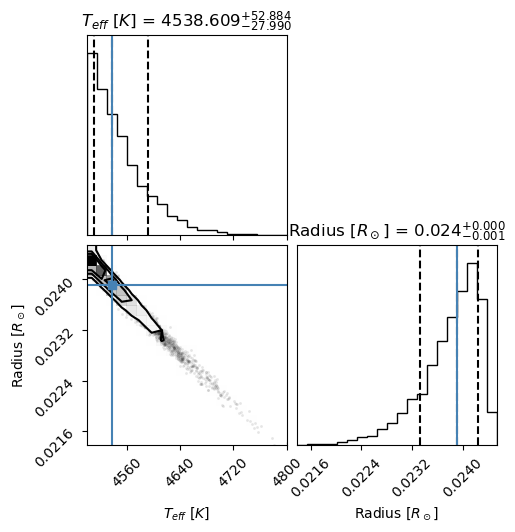

In [9]:
import corner

id = list(co_hdef_chains.keys())[21]

print(id)

labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
best_est = np.zeros((len(labels)))
unc = []

for i in range(len(labels)):
    mcmc = np.percentile(co_hdef_chains[id][:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(co_hdef_chains[id], labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

plt.show()

### Results (Gold Sample)

In [10]:
photo = cc.photometry.fetch_photometry(gold['wd_source_id']) # fetch PANSTARRS and DES photometry for the source_ids in the sample
gold = join(gold, photo, keys_left='wd_source_id', keys_right='source_id') # join the two on the wd source_id
gold_source_ids = gold['wd_source_id']


        SELECT gs.source_id, gs.original_ext_source_id
        FROM gaiadr3.panstarrs1_best_neighbour as gs
        WHERE gs.source_id in (321259125631010688, 2153552814748001792, 2376773024012888832, 3970162318385391488, 4248619071266347648, 4762592584885748608, 5309155039065680512, 5750618956285716480, 5924037812888396544)
        


In [11]:
gold['cmd_radius']

0.006786168093090157
0.0073973859146476235
0.006827360016277533
0.00695344430453521
0.0072459406314183674


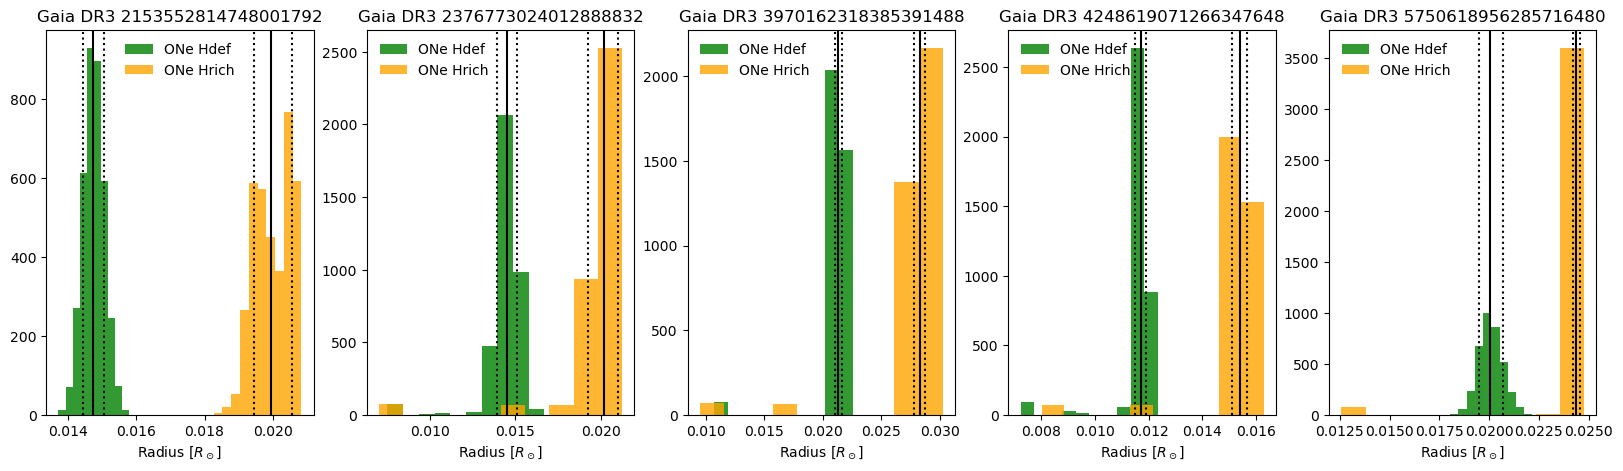

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20, 5))
burn = 0.25

for i in range(ax.shape[0]):
    id = gold_source_ids[i]

    ax[i].set_title(f'Gaia DR3 {id}')
    co_hdef_burn = int(burn * co_hdef_chains[id].shape[0])
    co_hrich_burn = int(burn * co_hrich_chains[id].shape[0])

    ax[i].hist(co_hdef_chains[id][co_hdef_burn:,1], color = 'green', alpha = 0.8, label = 'ONe Hdef')
    ax[i].hist(co_hrich_chains[id][co_hrich_burn:,1], color = 'orange', alpha = 0.8, label = 'ONe Hrich')
    ax[i].legend(framealpha=0)
    ax[i].set_xlabel(r'Radius $[R_\odot]$')

    co_hdef_mcmc = np.percentile(co_hdef_chains[id][:,1],[16,50,84])
    ax[i].axvline(x = co_hdef_mcmc[1], c = 'k')
    ax[i].axvline(x = co_hdef_mcmc[0], c = 'k', ls = ':')
    ax[i].axvline(x = co_hdef_mcmc[2], c = 'k', ls = ':')

    co_hrich_mcmc = np.percentile(co_hrich_chains[id][:,1],[16,50,84])
    ax[i].axvline(x = co_hrich_mcmc[1], c = 'k')
    ax[i].axvline(x = co_hrich_mcmc[0], c = 'k', ls = ':')
    ax[i].axvline(x = co_hrich_mcmc[2], c = 'k', ls = ':')

### Results (Silver)

In [13]:
photo = cc.photometry.fetch_photometry(silver['wd_source_id']) # fetch PANSTARRS and DES photometry for the source_ids in the sample
silver = join(silver, photo, keys_left='wd_source_id', keys_right='source_id') # join the two on the wd source_id
silver_source_ids = silver['wd_source_id']


        SELECT gs.source_id, gs.original_ext_source_id
        FROM gaiadr3.panstarrs1_best_neighbour as gs
        WHERE gs.source_id in (321259125631010688, 1158693871933588992, 2033937086539674752, 2084572311384460672, 2153552814748001792, 2376773024012888832, 2577004017102144256, 2809172631816775168, 3305291519719761280, 3552469739463127808, 3754176938580696064, 3970162318385391488, 4248619071266347648, 4595031204703995136, 4762592584885748608, 5309155039065680512, 5750618956285716480, 5924037812888396544, 6531698272762397824, 6716346888277566080)
        


In [14]:
len(silver_source_ids)

14

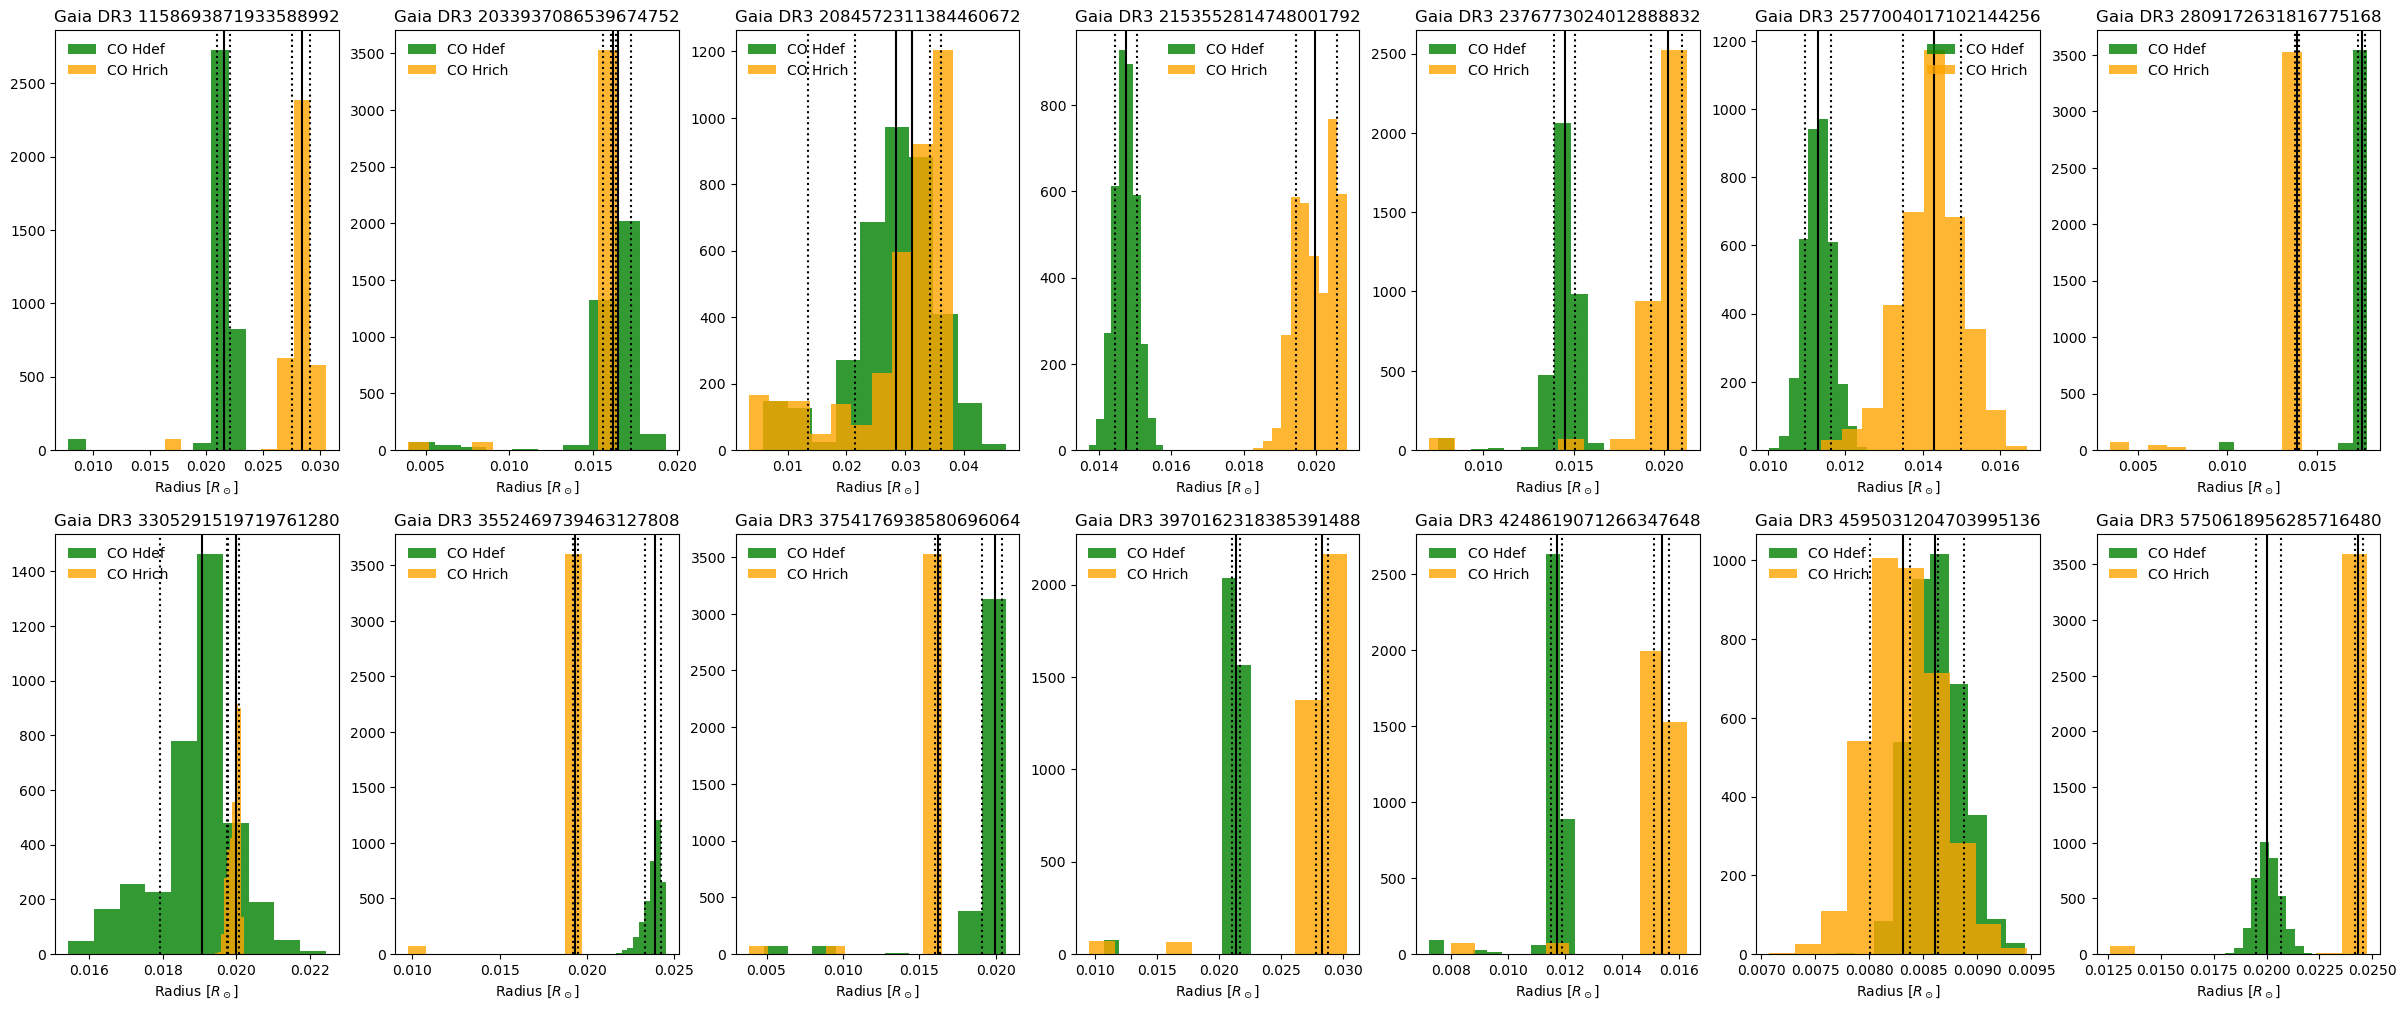

In [15]:
fig, ax = plt.subplots(nrows = 2, ncols = 7, figsize=(30, 12))
burn = 0.25

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        n = (i * ax.shape[1]) + j
        id = silver_source_ids[n]

        ax[i,j].set_title(f'Gaia DR3 {id}')
        co_hdef_burn = int(burn * co_hdef_chains[id].shape[0])
        co_hrich_burn = int(burn * co_hrich_chains[id].shape[0])

        ax[i,j].hist(co_hdef_chains[id][co_hdef_burn:,1], color = 'green', alpha = 0.8, label = 'CO Hdef')
        ax[i,j].hist(co_hrich_chains[id][co_hrich_burn:,1], color = 'orange', alpha = 0.8, label = 'CO Hrich')
        ax[i,j].legend(framealpha=0)
        ax[i,j].set_xlabel(r'Radius $[R_\odot]$')

        co_hdef_mcmc = np.percentile(co_hdef_chains[id][:,1],[16,50,84])
        ax[i,j].axvline(x = co_hdef_mcmc[1], c = 'k')
        ax[i,j].axvline(x = co_hdef_mcmc[0], c = 'k', ls = ':')
        ax[i,j].axvline(x = co_hdef_mcmc[2], c = 'k', ls = ':')

        co_hrich_mcmc = np.percentile(co_hrich_chains[id][:,1],[16,50,84])
        ax[i,j].axvline(x = co_hrich_mcmc[1], c = 'k')
        ax[i,j].axvline(x = co_hrich_mcmc[0], c = 'k', ls = ':')
        ax[i,j].axvline(x = co_hrich_mcmc[2], c = 'k', ls = ':')

In [16]:
gold[gold['wd_source_id'] == 5750618956285716480][['wd_ruwe', 'wd_phot_bp_rp_excess_factor', 'wd_phot_g_mean_mag']]

wd_ruwe,wd_phot_bp_rp_excess_factor,wd_phot_g_mean_mag
float64,float64,float64
0.9972977638244629,1.1353870630264282,19.951845169067383


In [17]:
np.where(obj.source_ids == 5750618956285716480)

(array([31]),)

In [18]:
source_ids = obj.source_ids[31]
distance = obj.geometry[31].distance.value
bands = obj.bands[31]
photomet = obj.photometry[31]
e_photomet = obj.e_photometry[31]
initial_guess = obj.initial_guess[31]

base_wavl, model_spec, model_spec_low_logg, table = cc.interpolator.utils.build_warwick_da()
build_spec = lambda best_est, distance : 4*np.pi*model_spec((best_est[0], 9)) * ((best_est[1] * 6.957e8) / (distance * 3.086775e16))**2

In [19]:
photomet[0:3]

array([19.95184517, 20.03573227, 19.84587097])

['Gaia_G' 'Gaia_BP' 'Gaia_RP']
[2.60741929e-17 3.95168683e-17 1.43327081e-17]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [212.32980423 209.84415729]


Auto-Correlation Time = 212.32980423377938, additional steps = 8541


100%|██████████| 8541/8541 [01:31<00:00, 93.80it/s] 


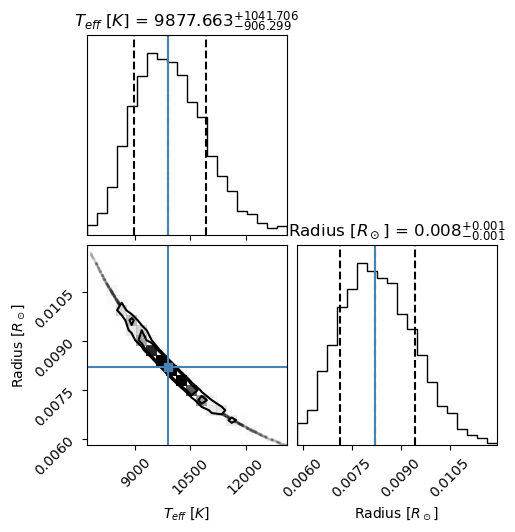

In [20]:
from corecomposition import interpolator

print(bands[0:3])
gaia_model = interpolator.WarwickDAInterpolator(bands[0:3])
# run the MCMC fit using one of the interpolators
gaia_engine = interpolator.MCMCEngine(gaia_model)
gaia_flat_chain = gaia_engine.run_mcmc(photomet[0:3], e_photomet[0:3], distance, initial_guess)

labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
best_est = np.zeros((len(labels)))
unc = []

for i in range(len(labels)):
    mcmc = np.percentile(gaia_flat_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(gaia_flat_chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

plt.show()

(4000.0, 11000.0)

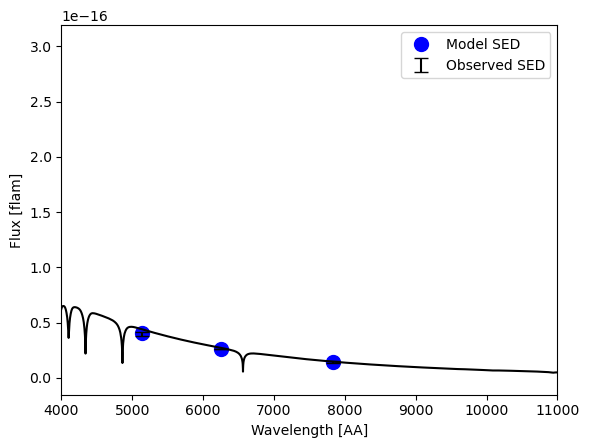

In [21]:
import pyphot
lib = pyphot.get_library()

model_flux = gaia_engine.get_model_flux(best_est, distance = distance)
flux, e_flux = gaia_engine.mag_to_flux(photomet[0:3], e_photomet[0:3])
wave = [lib[band].lpivot.to('angstrom').value for band in gaia_engine.bands]

plt.errorbar(wave, flux, yerr = e_flux, linestyle = 'none', marker = 'None', color = 'k',
                    capsize = 5, label = 'Observed SED', zorder=100)
plt.plot(wave, model_flux, 'bo', markersize = 10, label = 'Model SED')
plt.plot(base_wavl, build_spec(best_est, distance), c='k')
plt.xlabel(r'Wavelength [AA]')
plt.ylabel(r'Flux [flam]')
plt.legend()
plt.xlim(4000, 11000)

['PS1_g' 'PS1_r' 'PS1_i' 'PS1_z' 'PS1_y']
[5.18484192e-17 3.24004536e-17 2.15982761e-17 1.55669499e-17
 1.30452426e-17]
Auto-Correlation Time = 45.326301647440175, additional steps = -144


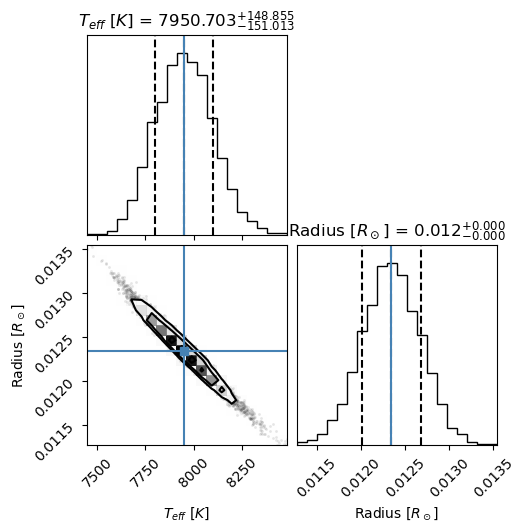

In [22]:
print(bands[3:])

#panstarrs_model = interpolator.LaPlataUltramassive(bands[3:], core = 'CO', layer = 'Hrich')
panstarrs_model = interpolator.WarwickDAInterpolator(bands[3:])
# run the MCMC fit using one of the interpolators
panstarrs_engine = interpolator.MCMCEngine(panstarrs_model)
panstarrs_flat_chain = panstarrs_engine.run_mcmc(photomet[3:], e_photomet[3:], distance, initial_guess)

labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
best_est = np.zeros((len(labels)))
unc = []

for i in range(len(labels)):
    mcmc = np.percentile(panstarrs_flat_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(panstarrs_flat_chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

In [23]:
bands

array(['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'PS1_g', 'PS1_r', 'PS1_i', 'PS1_z',
       'PS1_y'], dtype='<U7')

(4000.0, 11000.0)

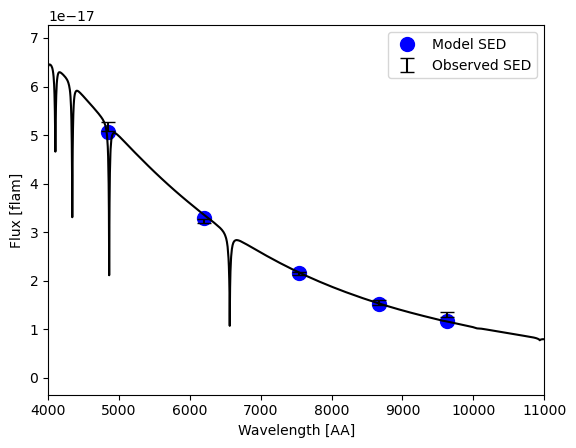

In [24]:
model_flux = panstarrs_engine.get_model_flux(best_est, distance = distance)
flux, e_flux = panstarrs_engine.mag_to_flux(photomet[3:], e_photomet[3:])
wave = [lib[band].lpivot.to('angstrom').value for band in panstarrs_engine.bands]

plt.errorbar(wave, flux, yerr = e_flux, linestyle = 'none', marker = 'None', color = 'k',
                    capsize = 5, label = 'Observed SED', zorder=100)
plt.plot(wave, model_flux, 'bo', markersize = 10, label = 'Model SED')
plt.plot(base_wavl, build_spec(best_est, distance), c='k')
plt.xlabel(r'Wavelength [AA]')
plt.ylabel(r'Flux [flam]')
plt.legend()
plt.xlim(4000, 11000)

['Gaia_G' 'Gaia_BP' 'Gaia_RP' 'PS1_g' 'PS1_r' 'PS1_i' 'PS1_z' 'PS1_y']
[2.60741929e-17 3.95168683e-17 1.43327081e-17 5.18484192e-17
 3.24004536e-17 2.15982761e-17 1.55669499e-17 1.30452426e-17]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [ 97.59105512 104.37010275]


Auto-Correlation Time = 104.37010274513412, additional steps = 2927


100%|██████████| 2927/2927 [00:59<00:00, 49.15it/s]


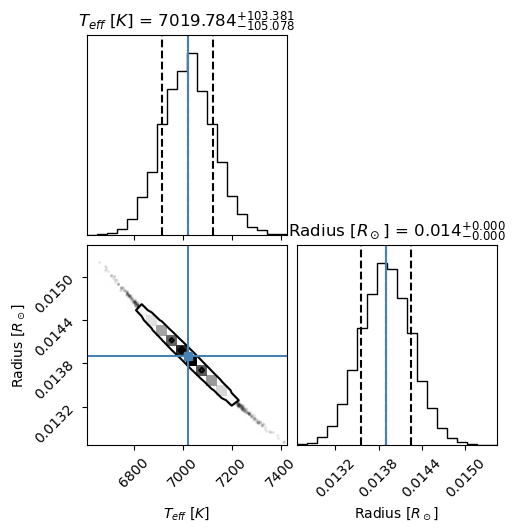

In [25]:
print(bands)
co_hrich_model = interpolator.WarwickDAInterpolator(bands)
# run the MCMC fit using one of the interpolators
engine = interpolator.MCMCEngine(co_hrich_model)
flat_chain = engine.run_mcmc(photomet, e_photomet, distance, initial_guess)

labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
best_est = np.zeros((len(labels)))
unc = []

for i in range(len(labels)):
    mcmc = np.percentile(flat_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(flat_chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

(4000.0, 11000.0)

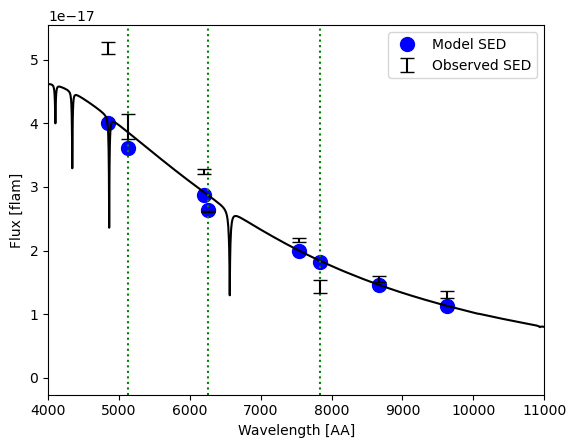

In [26]:
first_est = [9362, 0.009]

model_flux_best = engine.get_model_flux(best_est, distance = distance)
#model_flux_first = engine.get_model_flux(first_est, distance = distance)

flux, e_flux = engine.mag_to_flux(photomet, e_photomet)
wave = [lib[band].lpivot.to('angstrom').value for band in engine.bands]

plt.errorbar(wave, flux, yerr = e_flux, linestyle = 'none', marker = 'None', color = 'k',
                    capsize = 5, label = 'Observed SED', zorder=100)
plt.plot(wave, model_flux_best, 'bo', markersize = 10, label = 'Model SED')
plt.plot(base_wavl, build_spec(best_est, distance), c='k')

for i in range(3):
    plt.axvline(wave[i], c = 'green', ls = ':')

plt.xlabel(r'Wavelength [AA]')
plt.ylabel(r'Flux [flam]')
plt.legend()
plt.xlim(4000, 11000)